# Create Gaussian random fields with lya survey geometry to compute $C_{\ell}(k)$
- [x] generate GRFs with Lya bias and beta
- [x] draw skewers through box
- [x] FFT each skewer and construct $\delta_{2D}$ matrix
    - [x] do discrete version where multiplication of $\exp(i\mathbf(k)\mathbf{\chi})$
- [x] matrix of shape: (N_qso x N_kbins), so that in row i: ($\delta_F(k_0), \dots,\delta_F(k_N)$)
- [x] compute $$a_{\ell m}(\mathbf{k}) = \sum_j^{N_q} \delta_{2D}(x,y,z,k_i)Y_{\ell m}^{\ast}(x,y,j)$$
- [x] compute $$\hat{C}_{\ell}(k_i) = \texttt{hp.alm2cl}(a_lm(k_i))$$
- [ ] compute theory Eq. 2.13 in draft

In [2]:
3

3

In [3]:
%matplotlib inline
import numpy as np
from matplotlib_params_file import *
from numba import jit
import multiprocessing as mp
import healpy as hp
from scipy.linalg import dft
from scipy.interpolate import interp1d
from scipy.special import spherical_jn, legendre
from scipy.integrate import simps

#camb
import camb 
from camb import model, initialpower

# GRFs
import GRF_class as my_GRF

## create GRFs
- set `add_rsd=True' if you want to add RSD

In [4]:
GRF = my_GRF.PowerSpectrumGenerator(add_rsd=False)

Fundamental mode k_f= 0.004553032831289555
max mode k_f= 2.0188375532346075
Nyquist frequency: 1.165576404810126
ratio of Nyquist to fundamental freq 256.0
ratio of max to Nyquist freq 1.7320508075688774
beta 0.0
bias 1.0
RSD: False
get power spectrum from CAMB
define k grid
compute amplitudes
Include anisotropies False
compute mu = k_los / |k|
bias 1.0
beta 0.0
Transforming amplitudes to density field


In [5]:
# # UNCOMMENT to compute power spectrum with mode counting in spherical shells
# k_eff, p0_hat, p2_hat, p4_hat, counts, totcounts = GRF.compute_power_spectrum()
# # theory power spectrum anisotropic
# p0, p2, p4 = GRF.get_multipoles()

# ### compare theory to measurement
# plt.figure()
# plt.plot(GRF.kh_lin, GRF.kh_lin*p0, 'b-', label=r'$\ell=0$ (aniso)')
# plt.plot(GRF.kh_lin, GRF.kh_lin*p2, 'g-', label=r'$\ell=2$ (aniso)')
# plt.plot(GRF.kh_lin, GRF.kh_lin*p4, 'm-', label=r'$\ell=4$ (aniso)')
# plt.plot(k_eff, k_eff*p0_hat, 'bo--',label=r'$\hat{P}_{\ell=0}^{\mathrm{aniso}}(k)$')
# plt.plot(k_eff, k_eff*abs(p2_hat), 'go--',label=r'$\hat{P}_{\ell=2}^{\mathrm{aniso}}(k)$')
# plt.plot(k_eff, k_eff*abs(p4_hat), 'mo--',label=r'$\hat{P}_{\ell=4}^{\mathrm{aniso}}(k)$')
# plt.xlabel(r'$k\,[h$Mpc$^{-1}]$')
# plt.ylabel(r'$k\,P_\ell(k)\,[h^{-2}$Mpc$^{2}]$')
# plt.legend(ncol=2);plt.xlim(0., 0.5);
# #plt.ylim(0., 320)
# plt.show()



## Sample skewers
- Note that we apply a shift along the z axis. This is necessary to ensure that the $\mu$ angle is with respect to the z-axis
- computes $\mu$ with respect to the combined line-of-sight; $(\vec{r}_i+\vec{r}_j)/2$

In [6]:
# define number of qso drawn from the box
num_qso = int(1e+4)

In [7]:
all_x, all_y, all_z, all_w_rand, all_w_gal, Nskew = GRF.process_skewers(Nskew=num_qso)

N_skew = 9797 / 262144
Displacing box by 5.000e+03


In [8]:
def compute_theta_phi_skewer_start(x,y,z):
    # only compute the Theta, Phi angle for the *first* pixel of the Lya skewer

    xsq = x ** 2.
    ysq = y ** 2.

    s = (xsq + ysq) ** 0.5

    # convert to degrees
    phi = np.arctan2(y, x)
    theta = np.arctan2(s, z)
   
    return theta, phi

In [9]:
all_theta, all_phi = compute_theta_phi_skewer_start(all_x[:,0], all_y[:,0], all_z[:,0])
chi_grid = all_x[0,:]

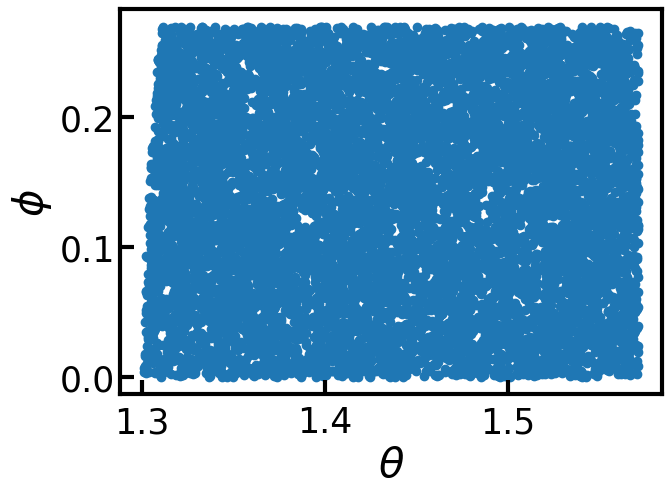

In [10]:
# theta, phi positions of skewers in the sky 
plt.figure(figsize=(7,5));plt.scatter(all_theta, all_phi);plt.xlabel(r'$\theta$');plt.ylabel(r'$\phi$');plt.show()

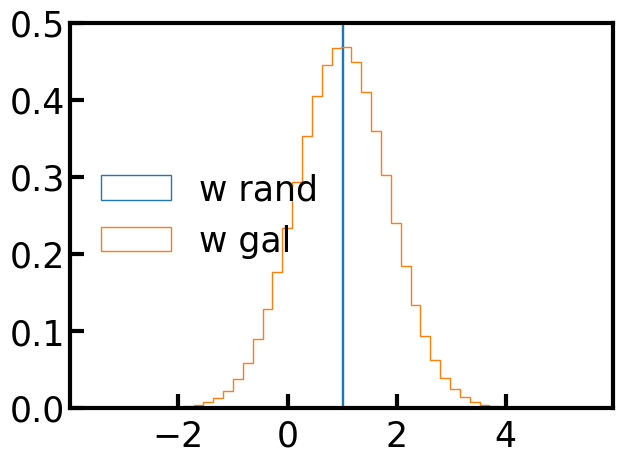

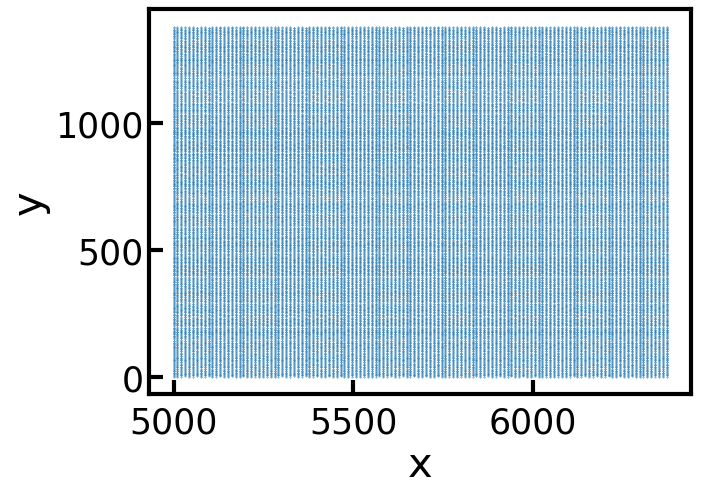

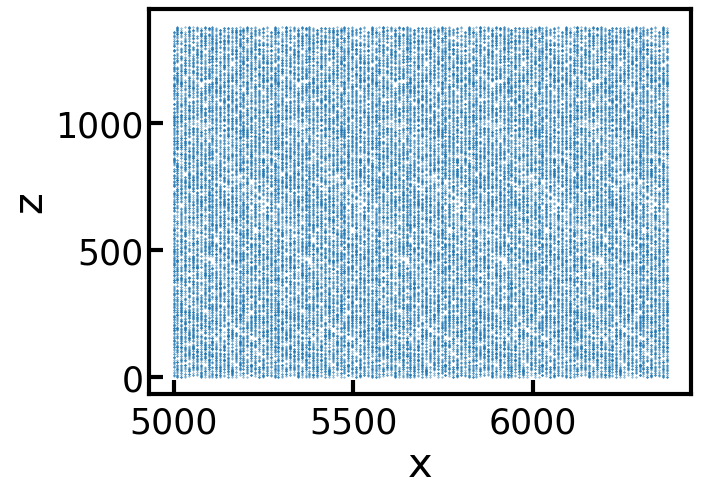

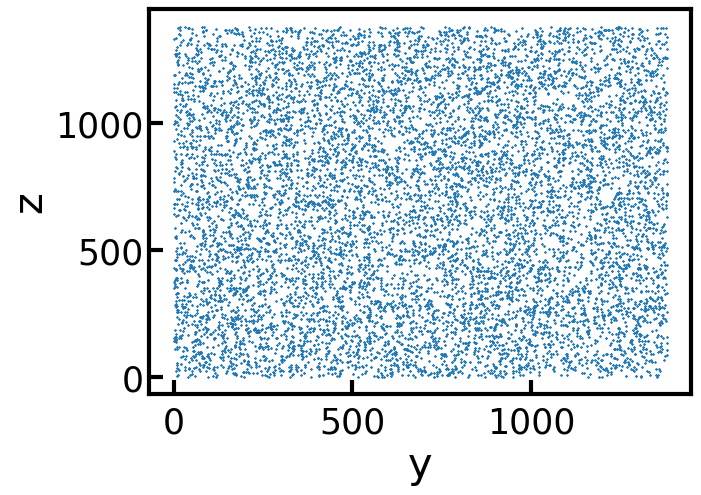

In [11]:
### Plot distribution of weights
plt.figure(figsize=(7,5));
plt.hist(all_w_rand.ravel(),density=True,histtype='step', bins=50, label='w rand');
plt.hist(all_w_gal.ravel(),density=True, histtype='step',bins=50, label='w gal');
plt.ylim(0., 0.5);plt.legend()
plt.show()

#### Visually check if skewers are taken through box
plt.figure(figsize=(7,5));plt.scatter(all_x.ravel()[::100],all_y.ravel()[::100],s=0.1);plt.xlabel('x');plt.ylabel('y');plt.show()
plt.figure(figsize=(7,5));plt.scatter(all_x.ravel()[::100],all_z.ravel()[::100],s=0.1);plt.xlabel('x');plt.ylabel('z');plt.show()
plt.figure(figsize=(7,5));plt.scatter(all_y.ravel()[::100],all_z.ravel()[::100],s=0.1);plt.xlabel('y');plt.ylabel('z');plt.show()

## compute discrete Fourier transform of matrix $N_{qso} \times N_{pix}$

- compute $\delta_{2D}(\hat{n}_j;k)$ for $\delta_{3D}=\delta_F(\chi\hat{n}_j)$ along each QSO sightline, $\hat{n}_j$, using FFTs [or as matrix-vector multiply of $\exp[ik\chi]$] with $K_j(\chi)\delta_F(\chi)$.
- Since the DESI QSO spectra all share a common wavelength grid, the ``matrix'' can be computed once.  It is convenient to store the real and imaginary parts separately.  
- same procedure on $K_j(\chi)$ not weighted by $\delta_F$ gives $\widetilde{K}_j(k)$.

- use $\delta_{2D}(\hat{n}_j;k)$ as weights for each QSO
- perform a spherical harmonic transform for each $k$
- For $\ell_{\rm max}=10^3$ and $10^6$ QSOs this takes a few seconds for each of the real and imaginary parts for each $k$.  
- Squaring the results and averaging over $m$ gives $C_\ell(k)$, which can be binned into bins of $\ell$ and normalized as desired.  

- compute the window matrix.  This is independent of the data, depending only upon the chosen weights, $K_j(\chi)$, and the QSO positions, $\hat{n}_j$.  If the matrix $\hat{n}_j\cdot\hat{n}_k$ is pre-computed, the sum over $\lambda$ can be done with recurrence relations and the final sum over $jk$ is a matrix product and trace though the final object depends upon $\ell$ (normally binned), $L$ and $k-k'$ and so can be large.  For very large numbers of sightlines, the sum over $j$ can be done in batches using the same procedure.


In [12]:
def compute_dft(chi_grid, mask, delta):
    # Ensure that chi_grid has a uniform step size
    diffs = np.diff(chi_grid)
    dx = diffs[0]
    assert np.allclose(diffs, dx), "Not all values in np.diff(chi_grid) are identical."

    # Number of points
    N = len(chi_grid)

    # Define k-array for Fourier transform
    k_arr = np.fft.fftfreq(N, d=dx)

    FT_mat = dft(N)
    # Perform the DFT using matrix multiplication
    FT_mask  = np.dot(mask, FT_mat)
    FT_delta = np.dot(delta, FT_mat)
    return k_arr, np.real(FT_mask), np.real(FT_delta)

In [13]:
k_arr, FT_mask, FT_delta = compute_dft(chi_grid, all_w_rand, all_w_gal)

### use directSHT to compute $C_{ell}$

In [14]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

2024-05-27 10:44:12.511014: W external/xla/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 42297524224
CUDA backend failed to initialize: INTERNAL: no supported devices found for platform CUDA (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


cpu


In [15]:
import sys
%env JAX_ENABLE_X64=True
#
sys.path.insert(0, '/global/homes/r/rmvd2/lya_Cl/directsht-lya/')
from sht.sht                import DirectSHT
from sht.mocks              import LogNormalMocks
from sht.mask_deconvolution import MaskDeconvolution
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

env: JAX_ENABLE_X64=True
cpu


In [16]:
# Set up an sht instance.
Nl   = 500
Nx   = 2*Nl
xmax = 5.0/8.0
#
sht= DirectSHT(Nl,Nx,xmax)
#
# We'll want to go to higher lmax in W_l to do mode-decoupling
buffer_ells = 64
sht_randoms = DirectSHT(Nl+buffer_ells,Nx,xmax)
#
print("For general, Direct SHT has Nl=",sht.Nell,", Nx=",Nx," and xmax=",xmax)
print("For randoms, Direct SHT has Nl=",sht_randoms.Nell,", Nx=",Nx," and xmax=",xmax)

/global/homes/r/rmvd2/lya_Cl/directsht-lya/sht/sht.py:47: UserWarning: Explicitly requested dtype float64 requested in arange is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  xx = jnp.arange(Nx, dtype=dflt_type) if jax_present else np.arange(Nx, dtype=dflt_type)


For general, Direct SHT has Nl= 500 , Nx= 1000  and xmax= 0.625
For randoms, Direct SHT has Nl= 564 , Nx= 1000  and xmax= 0.625


In [ ]:
tdata,pdata,wdata = all_theta, all_phi, FT_delta
trand,prand,wrand = all_theta, all_phi, FT_mask

In [ ]:
print(wrand.shape)
print(prand.shape)

(9797, 512)
(9797,)


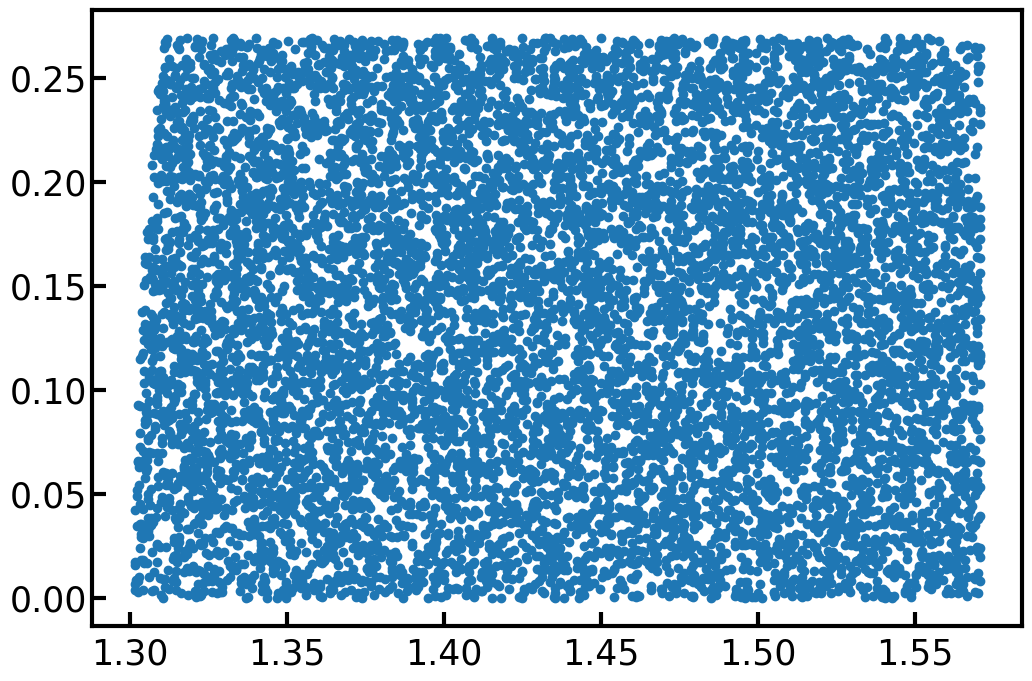

In [ ]:
plt.scatter(trand,prand);plt.show()

In [ ]:
# define index for calculation 
k_idx = 0
# To Do: do this in a loop

In [ ]:
# Calculate the angular power spectrum of the randoms
#
hran_for_wl = sht_randoms(trand,prand,wrand[:,k_idx])
#  After subtracting shot noise, this gives us the
#  angular power spectrum of the window function 
#sn = 1.0/float(nrand)/(4*np.pi) * float(ndata)**2
wl = hp.alm2cl(hran_for_wl)# - sn

Sorting & digitizing took  0.10887861251831055  seconds.
Reshaping took  0.0933370590209961  seconds.
Precomputing vs took  0.3150627613067627  seconds.
Computing alm's took  6.604129314422607  seconds.


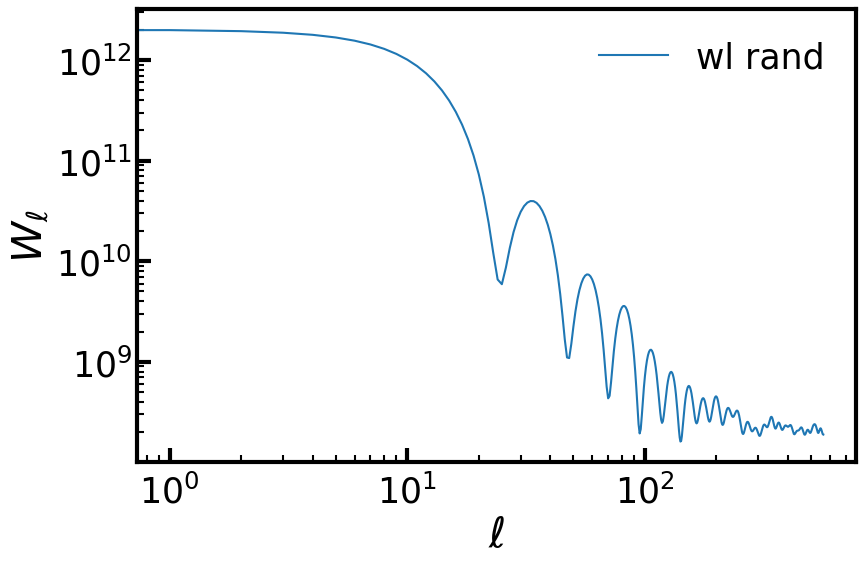

In [ ]:
plt.figure(figsize=(9,6))
plt.loglog(wl   ,label='wl rand')
#
plt.xlabel(r'$\ell$')
plt.ylabel(r'$W_\ell$')
plt.legend()
plt.tight_layout()
plt.savefig('./plots/harmonic_window.pdf')

In [ ]:
k_idx

0

## compute Wigner3j

In [ ]:
# if I want to use SHT for the Wigner3j computation
try:
    # Wigner3j code
    from timeit import default_timer as timer
    import fast_Wigner3j as Wigner3j
    print('use rmvd2 Wigner3j computation')

    #iitialize class
    couple_mat = Wigner3j.CoupleMat(Nl+buffer_ells, wl)
    # time execution code
    start = timer()
    coupling_matrix = couple_mat.compute_matrix()
    end = timer()

    # print elapsed time
    print('elapsed time {:1.5f}s'.format(end - start), flush=True)

    %time MD = MaskDeconvolution(Nl+buffer_ells,wl,precomputed_Wigner=coupling_matrix)
except:
    print('use SHT native Wigner3j computation')
    %time MD = MaskDeconvolution(Nl+buffer_ells,wl)
#
NperBin = 2**5
bins    = MD.binning_matrix('linear',0,NperBin)
Mbl     = MD.window_matrix(bins)
# Look at the sums over ell.
print("\nRow sums of Mbl:")
print(Mbl.sum(axis=1))

_fastmath False
_parallel True
_nopython False
use rmvd2 Wigner3j computation
start computation Wigner 3j symbols
elapsed time 0.81847s
Precomputing Wigner 3j symbols...
read in Wigner 3j matrix
CPU times: user 538 µs, sys: 407 µs, total: 945 µs
Wall time: 246 µs

Row sums of Mbl:
[1.00659986 1.00428365 1.00426153 1.00417394 1.00407949 1.00412353
 1.00423574 1.00421268 1.00393216 1.0039339  1.00419584 1.00441683
 1.00451371 1.00412838 1.008592   0.98772718 1.16683054]


### plot coupling matrix and window func

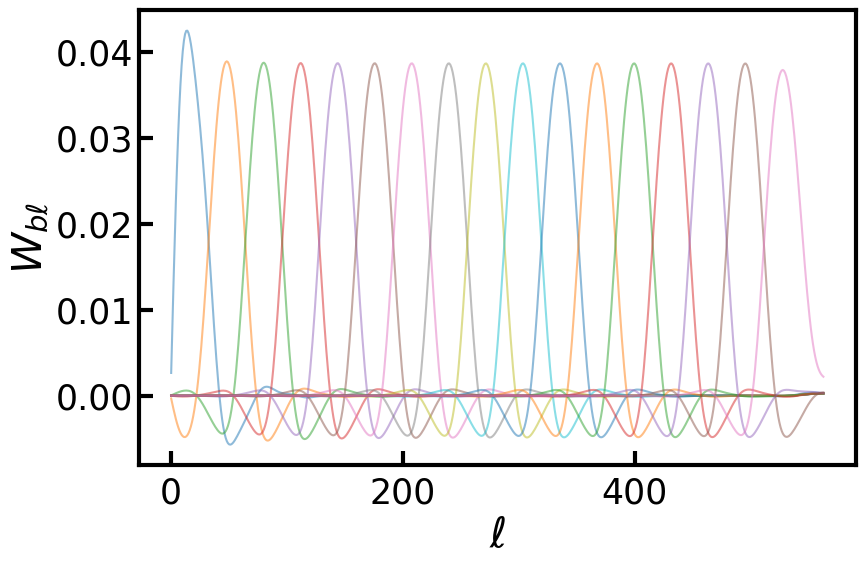

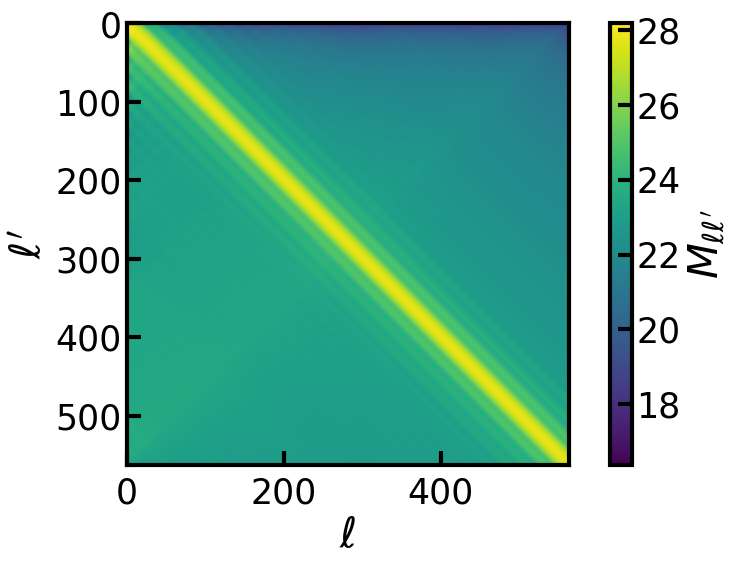

In [ ]:
# Plot the matrix:
fig,ax = plt.subplots(1,1, figsize=(9,6))
for i in range(Mbl.shape[0]):
    ax.plot(Mbl[i,:],alpha=0.5,label='Bin '+str(i))
#ax.legend(bbox_to_anchor=(1.1,1.0))
#ax.set_ylim(-0.07, 0.07)
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$W_{b\ell}$')
plt.tight_layout()
plt.savefig('./plots/harmonic_wbl.pdf', bbox_inches='tight')
#
# and plot the mode-coupling matrix itself.
fig,ax = plt.subplots(1,1, figsize=(9,6))
mode_coupling = np.log( 1+MD.Mll.clip(0,1e30) )
im = ax.imshow(mode_coupling.T)
ax.set_xlabel(r'$\ell$')
fig.colorbar(im, label=r'$M_{\ell \ell^\prime}$')
ax.set_ylabel(r'$\ell^\prime$')
plt.tight_layout()
plt.savefig('./plots/harmonic_mll.pdf', bbox_inches='tight')

### compute $C_{\ell}(k)$ for different values of $k$

In [ ]:
cl_k = []
# for k_idx in np.arange(0, 512, 200):
for k_idx in np.arange(0, 50, 15):
    hdat = sht(tdata,pdata,wdata[:,k_idx])
    # Do the same for the randoms.
    hran = sht(trand,prand,wrand[:,k_idx])
    # and for the difference of data and randoms:
    hdif = hp.alm2cl(hdat-hran)
    cl_k.append(hdif)
cl_k = np.stack(cl_k)

Sorting & digitizing took  0.0015819072723388672  seconds.
Reshaping took  0.021367311477661133  seconds.
Precomputing vs took  0.23708319664001465  seconds.
Computing alm's took  5.337891101837158  seconds.
Sorting & digitizing took  0.0015406608581542969  seconds.
Reshaping took  0.0209653377532959  seconds.
Precomputing vs took  0.15532541275024414  seconds.
Computing alm's took  5.268057107925415  seconds.
Sorting & digitizing took  0.001561880111694336  seconds.
Reshaping took  0.019917726516723633  seconds.
Precomputing vs took  0.15288066864013672  seconds.
Computing alm's took  5.256134271621704  seconds.
Sorting & digitizing took  0.0015707015991210938  seconds.
Reshaping took  0.01947021484375  seconds.
Precomputing vs took  0.15351414680480957  seconds.
Computing alm's took  5.610683441162109  seconds.
Sorting & digitizing took  0.0018265247344970703  seconds.
Reshaping took  0.023548126220703125  seconds.
Precomputing vs took  0.15890240669250488  seconds.
Computing alm's t

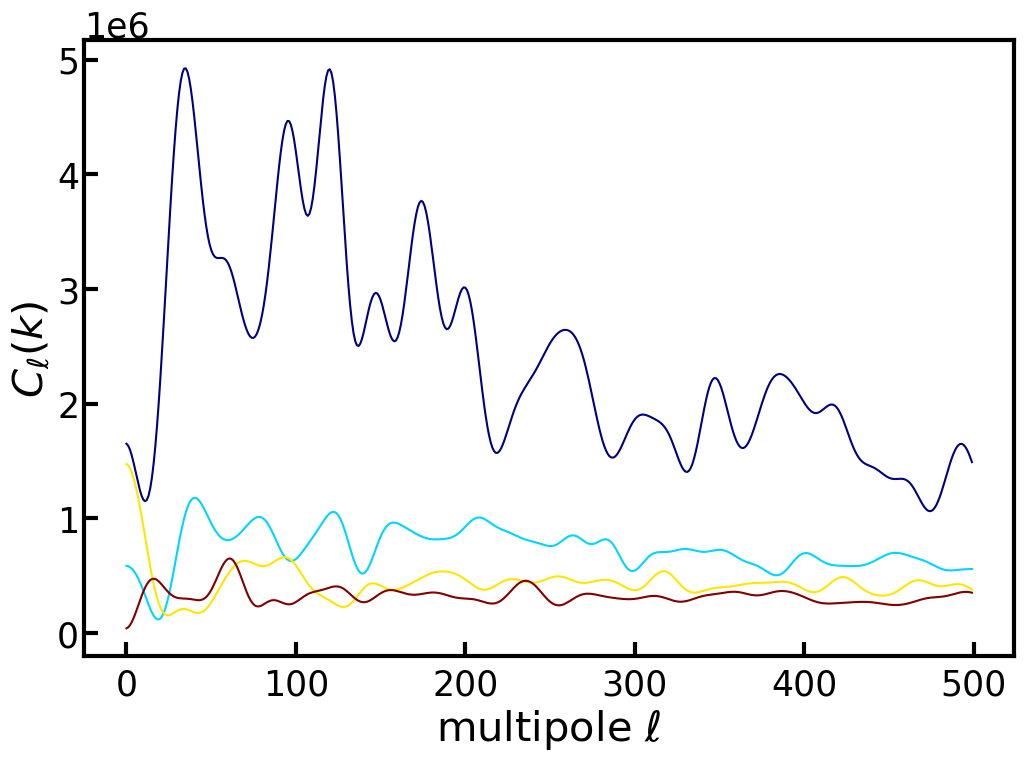

In [ ]:
n = len(cl_k)
colors = plt.cm.jet(np.linspace(0,1,n))

for k_idx in range(len(cl_k)):
    plt.plot(np.arange(sht.Nell), cl_k[k_idx],color=colors[k_idx])

plt.xlabel(r'multipole $\ell$')
plt.ylabel(r'$C_{\ell}(k)$')
plt.show()

In [ ]:
k_idx =0
# Get harmonic coefficients for the data and measure raw Cls
hdat = sht(tdata,pdata,wdata[:,k_idx])
# Do the same for the randoms.
hran = sht(trand,prand,wrand[:,k_idx])
# and for the difference of data and randoms:
hdif = hp.alm2cl(hdat-hran)
#print("hatC in range [{:e},{:e}]".format(np.min(hdif[1:]),np.max(hdif[1:])))

Sorting & digitizing took  0.0016803741455078125  seconds.
Reshaping took  0.020918846130371094  seconds.
Precomputing vs took  0.16224098205566406  seconds.
Computing alm's took  5.389955282211304  seconds.
Sorting & digitizing took  0.0016002655029296875  seconds.
Reshaping took  0.019338130950927734  seconds.
Precomputing vs took  0.1545405387878418  seconds.
Computing alm's took  5.367454767227173  seconds.


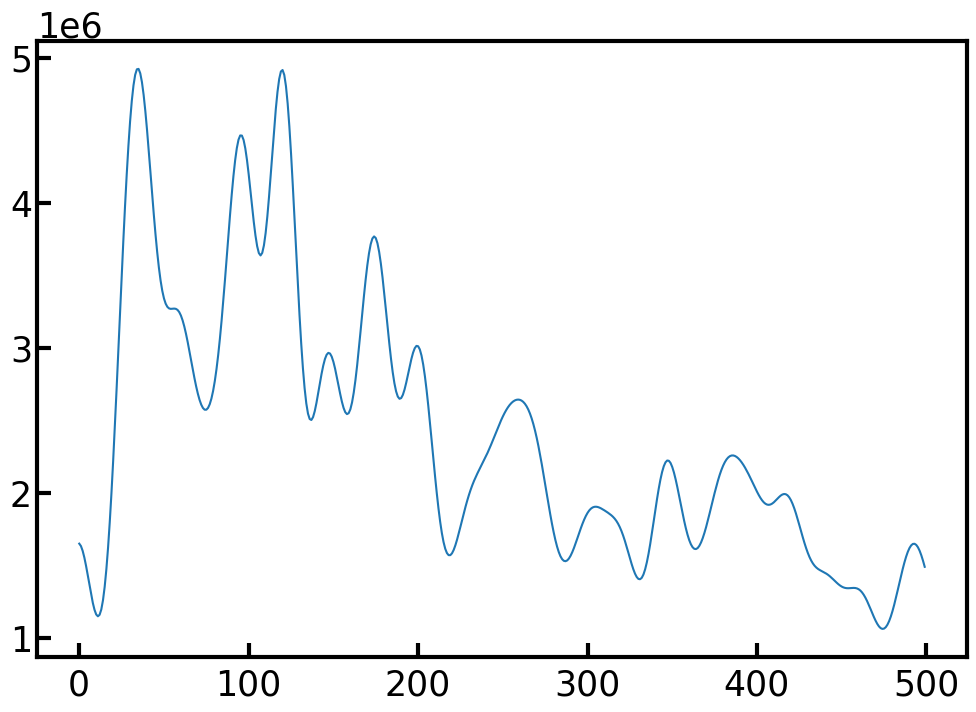

In [ ]:
plt.plot(hdif,label='hdif')

In [ ]:
# Now work out the binned and decoupled pseudo-spectrum.
# The first Ndiscard bins are removed because they have
# support to very low ell and the last bins because
# they have support past lmax
Ndiscard = 2
binned_ells,hdif_decoupled = MD(hdif,bins)
binned_ells,hdif_decoupled = binned_ells[Ndiscard:-Ndiscard],hdif_decoupled[Ndiscard:-Ndiscard]

In [ ]:
print(binned_ells)
print(hdif_decoupled)

[ 79.5 111.5 143.5 175.5 207.5 239.5 271.5 303.5 335.5 367.5 399.5 431.5
 463.5]
[8.82083918e-08 1.68286758e-07 7.47871033e-08 1.17214447e-07
 6.78542394e-08 7.20561185e-08 7.37532790e-08 5.36814339e-08
 5.57112011e-08 6.03535561e-08 7.38951789e-08 5.29499731e-08
 3.83138527e-08]


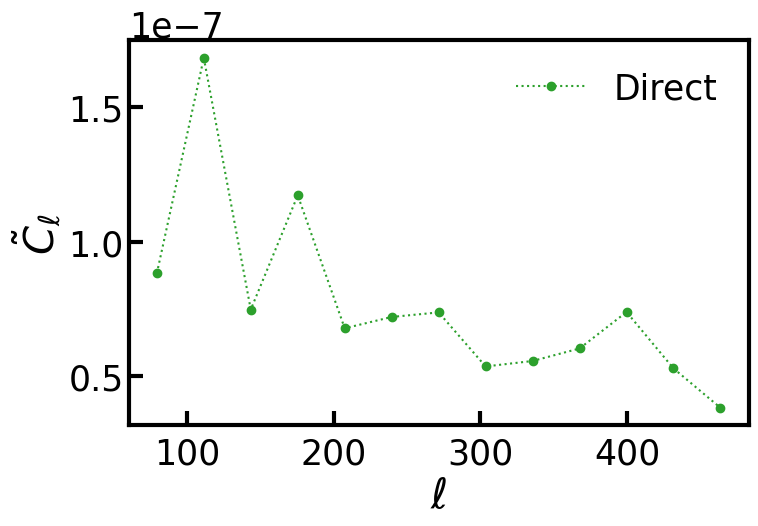

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(binned_ells,hdif_decoupled,'o:',color='C2',label='Direct')
#
# Compare to the theory convolved with the bandpower window function -- we
# expect some differences due to sample variance, but they shouldn't be huge.
# clt_conv = np.dot(Mbl,cl_theory[:Mbl.shape[1]])
# ax.plot(binned_ells, clt_conv[Ndiscard:-Ndiscard],'o:',color='C1',label='Theory')
#
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\tilde{C}_\ell$')
#
ax.legend()
plt.savefig('./plots/harmonic_tildeC.pdf', bbox_inches='tight')


# compute theory power spectrum 
$$\Large  C_\ell(k)  = \sum_{L \lambda}  F_{\ell L \lambda} \int\frac{dk'}{2\pi\,\bar{\chi}^2}\ P(L/\bar{\chi},k') \sum_{jk} P_\lambda(\hat{n}_j\cdot\hat{n}_k) \widetilde{K}_j^\star(k-k')\widetilde{K}_k(k-k') $$
Let's compute each element separately and then we'll put it all together
- Let's rewrite this $$\sum_{jk} P_\lambda(\hat{n}_j\cdot\hat{n}_k) \widetilde{K}_j^\star(k-k')\widetilde{K}_k(k-k') = \sum_{j} \widetilde{K}_j^\star(k-k') \left(\sum_kP_\lambda(\hat{n}_j\cdot\hat{n}_k) \widetilde{K}_k(k-k')\right)$$
- [x] we use the definition of $$ F_{\ell L \lambda} = \frac{(2L+1)(2\lambda+1)}{(4\pi)^2} \begin{pmatrix} \ell & L & \lambda \\ 0&0&0 \end{pmatrix}^2 $$

In [ ]:
print('use SHT native Wigner3j computation')
%time MD = MaskDeconvolution(Nl+buffer_ells,wl)

use SHT native Wigner3j computation
Precomputing Wigner 3j symbols...
Computing the mode-coupling matrix...
CPU times: user 2min 19s, sys: 952 ms, total: 2min 20s
Wall time: 2min 20s


In [ ]:
from scipy.special import eval_legendre
from scipy.integrate import quad

In [ ]:
Nskew

9797

In [ ]:
def compute_nhat(tdata, pdata):
    """
    Compute the nhat array given tdata and pdata.

    Parameters:
    tdata (np.ndarray): Array of theta data with shape (Nskew,)
    pdata (np.ndarray): Array of phi data with shape (Nskew,)

    Returns:
    np.ndarray: The computed nhat array with shape (Nskew, 3)
    """
    # Compute sin and cos of tdata and pdata
    sin_tdata = np.sin(tdata)
    cos_tdata = np.cos(tdata)
    sin_pdata = np.sin(pdata)
    cos_pdata = np.cos(pdata)

    # Compute nhat
    nhat = np.empty((tdata.shape[0], 3))
    nhat[:, 0] = sin_tdata * cos_pdata
    nhat[:, 1] = sin_tdata * sin_pdata
    nhat[:, 2] = cos_tdata

    return nhat

# To Do: use https://numba-special.readthedocs.io/en/latest/index.html to compute the Legendre polynomials quickly


def compute_PLKjKk(cos_theta_njnk, KjKk,lambda_idx=0):
    """
    Compute PLKjKk given input data.

    Parameters:
    tdata (np.ndarray): Array of theta data with shape (Nskew,)
    pdata (np.ndarray): Array of phi data with shape (Nskew,)
    FT_mask (np.ndarray): Array of FT_mask data with shape (Nskew, 512)
    k_idx (int): Index for the FT_mask (default is 0)
    lambda_idx (int): Index for the Legendre polynomial (default is 0)

    Returns:
    float: The computed PLKjKk value
    """

    # Compute KjKk for one k index
    # KjKk = np.outer(FT_mask[:, k_idx], FT_mask[:, k_idx])

    # Compute Legendre values and PLKjKk
    legendre_vals = eval_legendre(lambda_idx, cos_theta_njnk)
    PLKjKk = np.sum(legendre_vals) * KjKk

    return PLKjKk


def compute_PLKjKk_for_lambda(lambda_idx):
    return compute_PLKjKk(cos_theta_njnk, KjKk, lambda_idx)



In [ ]:
import multiprocessing

In [103]:
if __name__ == "__main__":
    lambda_max = 200
    nhat = compute_nhat(tdata, pdata)
    # Compute cos(theta_nj_nk)
    cos_theta_njnk = np.dot(nhat, nhat.T)
    KjKk = np.sum(np.outer(FT_mask[:, k_idx], FT_mask[:, k_idx]))
    num_cpus = 50  # Use all available CPUs

    # Create a pool of worker processes
    with multiprocessing.Pool(num_cpus) as pool:
        # Map the compute_PLKjKk function over the range of lambda values
        PLKjKk = pool.map(compute_PLKjKk_for_lambda, range(lambda_max))

    PLKjKk = np.array(PLKjKk)
    print(PLKjKk)

[2.41497341e+21 2.38650751e+21 2.33042742e+21 2.24840023e+21
 2.14283750e+21 2.01679372e+21 1.87383924e+21 1.71791419e+21
 1.55317095e+21 1.38381284e+21 1.21393692e+21 1.04738817e+21
 8.87631664e+20 7.37647855e+20 5.99854996e+20 4.76060767e+20
 3.67443792e+20 2.74563988e+20 1.97399249e+20 1.35404767e+20
 8.75903163e+19 5.26102130e+19 2.88604091e+19 1.45772234e+19
 7.93260765e+18 7.12148079e+18 1.04375132e+19 1.63347287e+19
 2.34733363e+19 3.07492462e+19 3.73076914e+19 4.25422213e+19
 4.60810120e+19 4.77629232e+19 4.76060198e+19 4.57713614e+19
 4.25247713e+19 3.81990492e+19 3.31587273e+19 2.77690209e+19
 2.23701387e+19 1.72576257e+19 1.26689466e+19 8.77610841e+18
 5.68378812e+18 3.43217617e+18 2.00358731e+18 1.33181138e+18
 1.31317617e+18 1.81835816e+18 2.70408931e+18 3.82405432e+18
 5.03843678e+18 6.22174108e+18 7.26867815e+18 8.09804880e+18
 8.65468192e+18 8.90958439e+18 8.85853264e+18 8.51938570e+18
 7.92842616e+18 7.13604427e+18 6.20207256e+18 5.19105912e+18
 4.16773812e+18 3.192920

In [104]:
ell_range = np.concatenate([np.arange(2, 100, 10)])

def Power_spectrum(kh_par, ell, chi):
    kh = np.sqrt(kh_par**2 + (ell/(chi))**2)
    return GRF.plin(kh)

def F_ell_L_lambda(ell, L, lambda_):
    # Compute the prefactor
    prefactor = (2*L + 1) * (2*lambda_ + 1) / (4 * np.pi)**2
    
    # Compute the Wigner 3-j symbol
    wigner_3j_value = MD.w3j000(ell, L, lambda_)**2
    
    # Compute the final value of F_{ell L lambda}
    F_value = prefactor * wigner_3j_value
    
    return float(F_value)

lambda_max = len(PLKjKk)
L_max = 100

k_range = np.arange(1)
Cl_int = np.zeros((len(ell_range), len(k_range)))

print('compute for', k_idx, 'with chibar: ', chi_grid[k_idx])
chi_bar = chi_grid[k_idx]
# only compute C_ell(k=0) for now
for ell_idx,ell_val in enumerate(ell_range):
    print('compute for ell idx=', ell_val, 'and ell=', ell_val)
    for L in range(L_max):
        print('compute for L=', L)
        for lambda_ in range(lambda_max):
            print('compute for lambda=', lambda_)
            Cl_int[ell_idx, k_idx] += F_ell_L_lambda(ell_val, L, lambda_)*Power_spectrum(kh_par=k_arr[k_idx], ell=L, chi=chi_bar)/(2.*np.pi*chi_bar**2) * PLKjKk[lambda_]

compute for 0 with chibar:  5000.0
compute for ell idx= 2 and ell= 2
compute for L= 0
compute for lambda= 0
compute for lambda= 1
compute for lambda= 2
compute for lambda= 3
compute for lambda= 4
compute for lambda= 5
compute for lambda= 6
compute for lambda= 7
compute for lambda= 8
compute for lambda= 9
compute for lambda= 10
compute for lambda= 11
compute for lambda= 12
compute for lambda= 13
compute for lambda= 14
compute for lambda= 15
compute for lambda= 16
compute for lambda= 17
compute for lambda= 18
compute for lambda= 19
compute for lambda= 20
compute for lambda= 21
compute for lambda= 22
compute for lambda= 23
compute for lambda= 24
compute for lambda= 25
compute for lambda= 26
compute for lambda= 27
compute for lambda= 28
compute for lambda= 29
compute for lambda= 30
compute for lambda= 31
compute for lambda= 32
compute for lambda= 33
compute for lambda= 34
compute for lambda= 35
compute for lambda= 36
compute for lambda= 37
compute for lambda= 38
compute for lambda= 39
comp

Text(0, 0.5, '$C_{\\ell}(k=0)$')

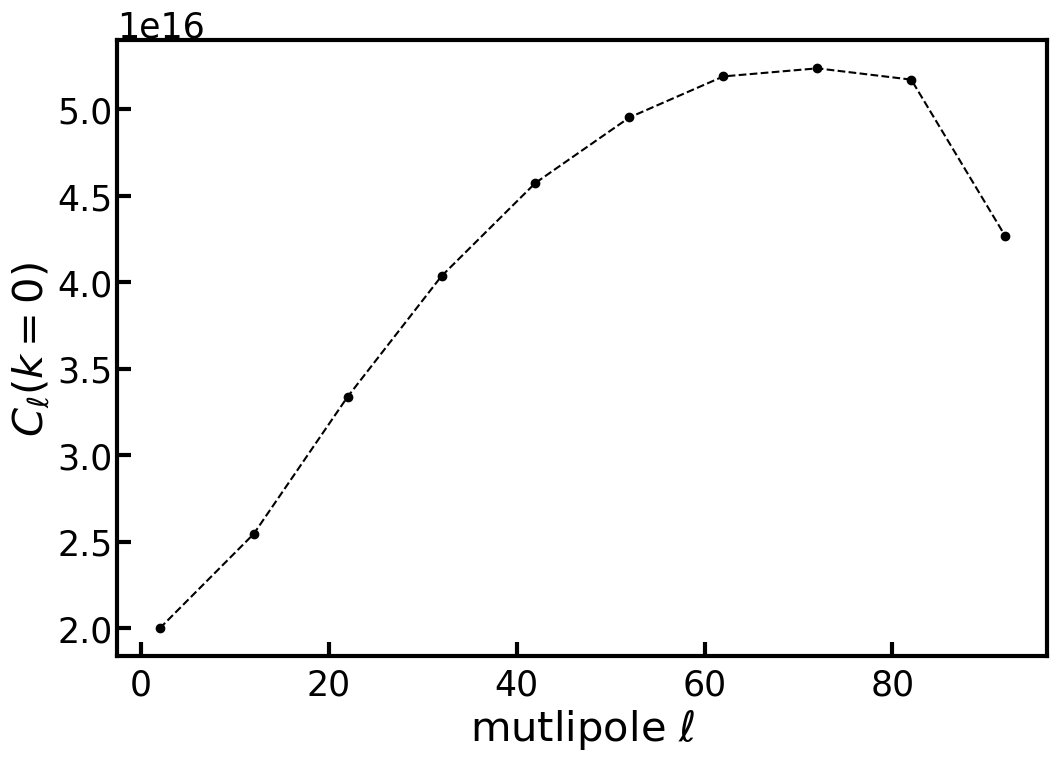

In [106]:
plt.plot(ell_range, Cl_int, 'ko--')
plt.xlabel(r'mutlipole $\ell$')
plt.ylabel(r'$C_{\ell}(k=0)$')

In [39]:
def Power_spectrum(kh_par, ell, chi):
    kh = np.sqrt(kh_par**2 + (ell/(chi))**2)
    return GRF.plin(kh)

def Cell(l, k_min, k_max, chi_bar, k_idx, lambda_idx):
    def integrand(kint):
        # pk_chi2 = Power_spectrum(kh_par=0, ell=l, chi=chi)/(chi**2)
        pk_chi2 = Power_spectrum(kh_par=kint, ell=l, chi=chi_bar)/(chi_bar**2)*compute_PLKjKk(tdata, pdata, FT_mask, k_idx=k_idx, lambda_idx=lambda_idx)
        return pk_chi2/(2.*np.pi)
    return quad(integrand, k_min, k_max)[0]

#Limber's approximation
kh = np.linspace(1e-4, 10, 5000)
# 2-500 in bins of 10 after 100 
ell_range = np.concatenate([np.arange(2, 100), np.arange(100, 510, 10)])
ell_range = np.concatenate([np.arange(2, 100, 10)])
#Cell = np.array([Cell(li, 0.1, 1000) for li in ell_range])

[]

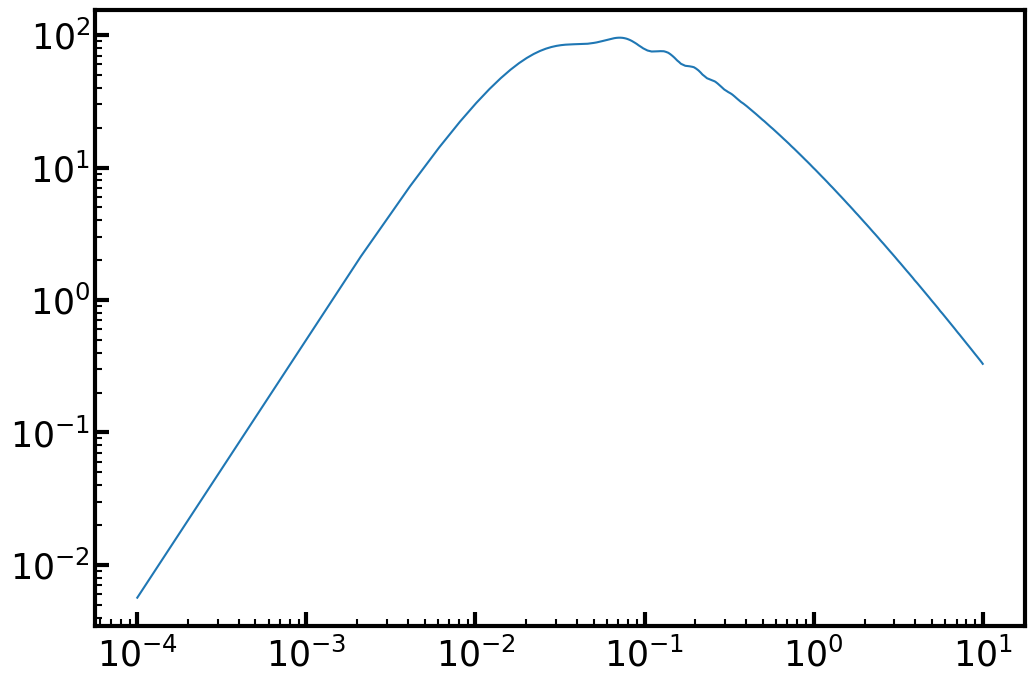

In [40]:
plt.plot(kh, kh*GRF.plin(kh));plt.loglog()

In [41]:
k_range = np.arange(1)
Cl_int = np.zeros((len(ell_range), len(k_range)))

for k_idx in k_range:
    print('compute for', k_idx, 'with chibar: ', chi_grid[k_idx])
    chi_bar = chi_grid[k_idx]
    # only compute C_ell(k=0) for now
    for ell_idx in ell_range:
        print('compute for ell=', ell_idx)
        for L in range(1):
            print('compute for L=', L)
            for lambda_ in range(1):
                print('compute for lambda=', lambda_)
                Cl_int[ell_idx, k_idx] = F_ell_L_lambda(ell_idx, L, lambda_)*Cell(ell_idx, 0.01, 10, chi_bar, k_idx, lambda_)

compute for 0 with chibar:  5000.0
compute for ell= 2
compute for L= 0
compute for L= 0


KeyboardInterrupt: 